In [1]:
import sys
import os

# from Utilities.NLP_ModelTrainers.SentenceClassification.MulticlassSentenceClassificationModule import MulticlassSentenceClassificationTrainerModule

from nlp_datasets import YahooDataset
from nlp_datasets import BaseDataset
# from nlp_datasets import SpellingSimilarityDataset
from nlp_modeltrainers import BaseTrainerModule
# from nlp_modeltrainers import VectorCosineSimilarityTrainerModule


import torch
import fastwer
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.nn import Module, Linear, Embedding
from torch.utils.data import DataLoader

from nltk import word_tokenize

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from pytorch_lightning import LightningModule

if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = 'cpu'

device = torch.device(dev)

In [2]:
class subwordhash:
    def __init__(self, dataset):
#         hash_len, sample_len = self.average_subword_num(dataset)
        self.max_hash = 377
        self.max_sample = 995
        
    def __call__(self, word):
        return self.subword_hashes(word, max_hash_num = self.max_hash)
    
    def fnv1a(self, txt, K = int(2e6 + 1)):
        # 64 bit fnv-1a
        txt = bytes(txt, 'utf-8')
        hval = 0xcbf29ce484222325
        fnv_prime = 0x100000001b3
        for c in txt:
            hval = hval ^ c
            hval = (hval * fnv_prime) % K
        return hval + 1        

    def subword_hashes(self, word, max_hash_num = None, get_len = False):
        sub_hash = []
        tword = '<' + word + '>'
        sub_hash.append(self.fnv1a(tword))
        for n in range(3,7):
            for i in range(len(tword)-n+1):
                sub_hash.append(self.fnv1a(tword[i:i+n]))
        if max_hash_num is not None:
            sub_hash.extend([0]*(max_hash_num - len(sub_hash)))
        if get_len:
            return len(sub_hash)
        return np.array(sub_hash)

    def average_subword_num(self, dataset):
        max_sample_len = 0
        hash_len_dist = {}
        len_dist = {}
        for sample in tqdm(dataset):
            tokens = word_tokenize(sample["input"])
            if len(tokens) not in len_dist:
                len_dist[len(tokens)] = 0
            len_dist[len(tokens)] += 1
            max_sample_len = max(max_sample_len, len(tokens))
            
        for L in list(len_dist):
            hash_len_dist[self.subword_hashes('a'*L, get_len = True)] = len_dist[L]
        
        total = 0
        weighted_hash_len = []
        for L in list(hash_len_dist):
            total += hash_len_dist[L]
            weighted_hash_len.append(hash_len_dist[L]*L)
        avg = sum(weighted_hash_len)/total
        
        return int(avg), max_sample_len
        

In [3]:
max_samples = 10000
batch_size = 16
emb_dim = 100
num_emb = int(2e6+1)
context_size = 3
neg_num = 5
uniform = False
max_epochs = None

if uniform: dist = 'uniform'
else: dist = 'noisedist'
if max_epochs is None:
    epoch = 'ULepochs'
else: epoch = f'{max_epochs}e'
save_path = f"./SubwordEmbedding/trained_model/trained_model_{emb_dim}d_{dist}_{epoch}"

In [4]:
with open("../NLP_Utilities/NLP_Datasets/datasets/spelling_similarity_corpus/words_corpus.txt", "r") as f:
    words_corpus = [line.split(":") for line in f.read().split("\n")]
    
with open("../NLP_Utilities/NLP_Datasets/datasets/spelling_similarity_corpus/anagram_corpus.txt", "r") as f:
    anagram_corpus = [line.split(":") for line in f.read().split("\n")]
    
with open("../NLP_Utilities/NLP_Datasets/datasets/spelling_similarity_corpus/misspellings_corpus.txt", "r") as f:
    misspellings_corpus = [line.split(":") for line in f.read().split("\n")]

In [23]:
class SubwordEmbedding(Module):
    def __init__(self, num_embeddings, embedding_dim, device, padding_idx = 0):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.device =  device
        self.padding_idx = padding_idx
        
        self.subword_embedding = Embedding(num_embeddings = num_embeddings, 
                                           embedding_dim = embedding_dim, 
                                           padding_idx = padding_idx)
    def forward(self, token_ids):
        # token_ids: (batch_size, word_num, hash_size)
        # return: (batch_size, word_num, embedding_dim)
        debug = False
        
        subword_embed = self.subword_embedding(token_ids)
        # (batch_size, word_num, hash_size, embedding_dim)
        if debug: print("subword_embed.shape: ", subword_embed.shape)
        
        word_embed = subword_embed.sum(dim = len(subword_embed.shape) -2).to(self.device)
        # (batch_size, word_num, embedding_dim)
        if debug: print("word_embed.shape: ", word_embed.shape)
        
        if debug: print("\n########################################\n")
        return word_embed
        

In [25]:
word_embedding = SubwordEmbedding(num_embeddings = num_emb, embedding_dim = emb_dim, device = device, padding_idx = 0)
word_embedding.load_state_dict(torch.load(save_path))
print(f'Loaded model: trained_model_{emb_dim}d_{dist}_{epoch}')
print(word_embedding.num_embeddings)

Loaded model: trained_model_100d_noisedist_ULepochs
2000001


In [26]:
dataset = YahooDataset(max_samples=max_samples, local_dir="small_yahoo_dataset")
subword_hashes = subwordhash(dataset.train)

max_sw_hash_len = subword_hashes.max_hash
max_sample_len = subword_hashes.max_sample
print(max_sw_hash_len)
print(max_sample_len)

377
995


In [29]:
def similarity_eval(word_corpus, word_embedding):
    mae = []
    less = []
    more = []
    similarities = []
    target_similarities = []
    for w in tqdm(word_corpus):
        w1 = subword_hashes(w[0])
        w2 = subword_hashes(w[1])
        subword_embed = word_embedding.subword_embedding(torch.tensor([w1,w2],dtype = torch.long)).to(device)
        word_embed = subword_embed.sum(dim = len(subword_embed.shape) -2).unsqueeze(1).to(device)
#         print(word_embed[0].shape, word_embed[1].shape)
        model_sim = float(F.cosine_similarity(word_embed[0], word_embed[1]))
        similarities.append(model_sim)
        target_sim = 1 - fastwer.score_sent(w[0], w[1], char_level = True)/100
        target_similarities.append(target_sim)
        mae.append(abs(target_sim - model_sim))
        if target_sim - model_sim >=0:
            less.append(abs(target_sim - model_sim))
        elif target_sim - model_sim < 0:
            more.append(abs(target_sim - model_sim))
            
    print(f"MAE: {np.mean(mae)}")
    print(f"MAE (More): {np.mean(more)}")
    print(f"MAE (Less): {np.mean(less)}")
    plt.figure(figsize=[20,5])
    plt.plot(similarities)
    plt.plot(target_similarities)
    plt.xticks(range(0,20), labels=range(1,21))
    plt.grid()
    plt.show()
    
def similarity_plot(word_embedding, max_char_len = 20):
    np.random.seed(0)
    words_num = 1000
    chars = list('qwertyuiopasdfghjklzxcvbnm')
    similarities = []
    target_similarities = []
    for char_len in tqdm(range(1,max_char_len +1)):
        g_words1 = ["".join(sampling_chars) for sampling_chars in np.random.choice(chars, size=[words_num, char_len], replace=True)]
        g_words2 = ["".join(sampling_chars) for sampling_chars in np.random.choice(chars, size=[words_num, char_len], replace=True)]
        
        gw1 = [subword_hashes(w) for w in g_words1]
        gw2 = [subword_hashes(w) for w in g_words2]
        subword_embed = word_embedding.subword_embedding(torch.tensor([gw1,gw2],dtype = torch.long)).to(device)
        g_word_embed = subword_embed.sum(dim = len(subword_embed.shape) -2).to(device)
#         print(g_word_embed.shape)
        model_sim = F.cosine_similarity(g_word_embed[0], g_word_embed[1]).to(torch.device("cpu")).detach().numpy()
#         print(model_sim.shape)
        similarities.append(model_sim.mean())
        target_sim = 1 - fastwer.score(g_words1, g_words2, char_level = True)/100
#         print(target_sim)
        target_similarities.append(target_sim)
    
    plt.figure(figsize=[20,5])
    plt.plot(similarities)
    plt.plot(target_similarities)
    plt.xticks(range(0,20), labels=range(1,21))
    plt.grid()
    plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████| 502/502 [00:00<00:00, 1371.47it/s]


MAE: 0.42235632798471734
MAE (More): 0.005327253136783838
MAE (Less): 0.42402444428410907


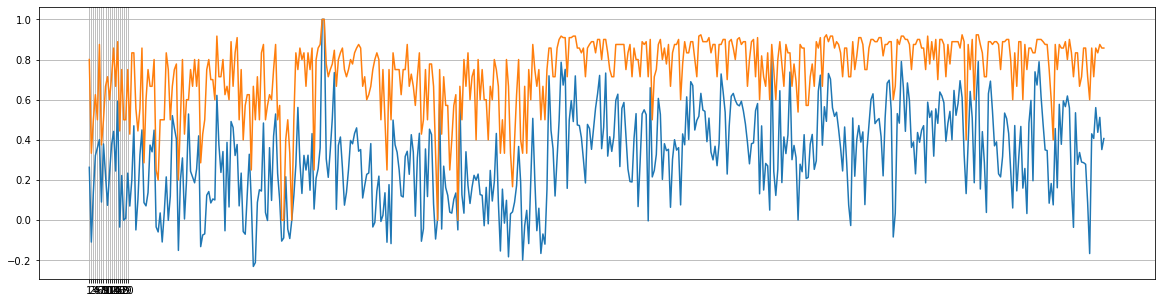

In [30]:
similarity_eval(misspellings_corpus, word_embedding)

100%|███████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.80it/s]


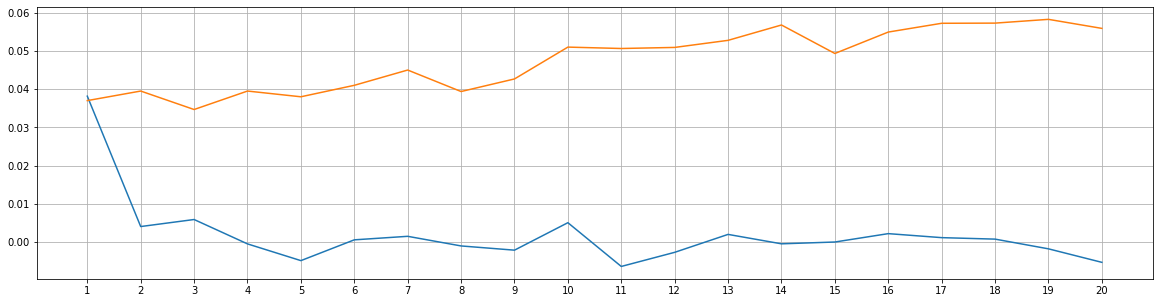

In [6]:
misspellings_corpus[0]

['abaout', 'about', '0.833333']

In [11]:
t1 = torch.tensor([[1,1,1,1],[2,2,2,2],[3,3,3,3]], dtype = torch.long)
t2 = torch.rand()
out = F.cosine_similarity(t1,t2)
print(out.shape)
print(out)

TypeError: rand() received an invalid combination of arguments - got (), but expected one of:
 * (tuple of ints size, *, torch.Generator generator, tuple of names names, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, torch.Generator generator, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, tuple of names names, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


In [ ]:
import fastwer
hypo = ['transporting']
ref = ['black']

a = fastwer.score_sent(hypo[0], ref[0], char_level=True)
print(1-a/100)